## Практическое задание
Попробуйте видоизменить параметры разобранной на уроке нейронной сети таким образом, чтобы улучшить её точность. Проведите анализ:

* Что приводит к ухудшению точности нейронной сети?
* Что приводит к увеличению её точности?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def to_one_hot(Y):
    '''преобразование массива в бинарный вид результатов'''
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

def sigmoid(x):
    '''сигмоида'''
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    '''производная сигмоиды'''
    return sigmoid(x)*(1 - sigmoid(x))

def normalize(X, axis=-1, order=2):
    '''нормализация массива'''
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

def data_preparation(file = "Iris.csv"):
    '''подготовка данных'''
    iris_data = pd.read_csv("Iris.csv")
    iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)
    columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
    x = pd.DataFrame(iris_data, columns=columns)
    x = normalize(x.to_numpy())
    columns = ['Species']
    y = pd.DataFrame(iris_data, columns=columns)
    y = y.to_numpy()
    y = y.flatten()
    y = to_one_hot(y)
    return train_test_split(x, y, test_size=0.33, random_state=42)

def fit_neuro(X_train, y_train, neurons = 5, hidden_layers = 1, inerations = 10000, lr = 0.01, flag=False):
    '''Инициализация и обучение модели нейронной сети'''
    # инициализация весов
    np.random.seed(42)
    w = []
    w.append(2*np.random.random((4, neurons))-1)
    for layer in range(hidden_layers-1):
        w.append(2*np.random.random((neurons, neurons))-1)
    w.append(2*np.random.random((neurons, 3))-1)
    errors = []
    # процесс обучения
    for i in range(1, inerations):
        # прямой проход        
        layer = [0]        
        layer[0] = X_train
        for index in range(len(w)):
            layer.append(sigmoid(np.dot(layer[index], w[index]))) 
        # обратный проход        
        layer_error = [0]*(hidden_layers+2)
        layer_delta = [0]*(hidden_layers+2)
        layer_error[-1] = y_train - layer[-1]
        layer_delta[-1] = layer_error[-1] * sigmoid_deriv(np.dot(layer[-2], w[-1]))
        for index in range(hidden_layers, 0, -1):
            layer_error[index] = layer_delta[index+1].dot(w[index].T)
            layer_delta[index] = layer_error[index] * sigmoid_deriv(np.dot(layer[index-1], w[index-1]))        
        # корректировка весов
        for index in range(len(w)):
            w[index] += layer[index].T.dot(layer_delta[index+1]) * lr
        error = np.mean(np.abs(layer_error[-1]))
        errors.append(error)
        accuracy = (1 - error) * 100    
    # вспомогательная отрисовка результата 
    if flag:
        plt.plot(errors)
        plt.xlabel('Обучение')
        plt.ylabel('Ошибка')        
        print("Точность нейронной сети " + str(round(accuracy,2)) + "%")    
    return w

In [3]:
def predict(w, X_test):
    '''предсказание сети'''
    layer = [0.0]
    layer[0] =  sigmoid(np.dot(X_test, w[0]))
    for index in range(1, len(w)):
        layer.append(sigmoid(np.dot(layer[index-1], w[index])))
    return layer[-1]

In [4]:
def accuracy(true, pred):
    '''расчёт accuracy'''
    # представление данный в виде одномерных массивов с метками классов
    true_ =  [el.argmax() for el in true]
    pred_ = [el.argmax() for el in pred]
    return accuracy_score(true_, pred_)

## BaseLine

In [5]:
X_train, X_test, y_train, y_test =  data_preparation()
w = fit_neuro(X_train, y_train, neurons = 5, hidden_layers = 1, inerations = 10000, lr = 0.01)
pred_train = predict(w ,X_train)
print('accuracy train - ', accuracy(y_train, pred_train))
pred_test = predict(w ,X_test)
print('accuracy test  - ',accuracy(y_test, pred_test))


accuracy train -  0.98
accuracy test  -  0.96


In [6]:
print(classification_report(y_test.argmax(-1), pred_test.argmax(-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.94      0.94      0.94        16
           2       0.93      0.93      0.93        15

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



In [7]:
print(multilabel_confusion_matrix(y_test.argmax(-1), pred_test.argmax(-1)))

[[[31  0]
  [ 0 19]]

 [[33  1]
  [ 1 15]]

 [[34  1]
  [ 1 14]]]


## Изменение результатов работы сети в завичсимости от скорости обучение

In [8]:
lr = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2]
acc_train = []
acc_test = []  
for rate in lr:
    w = fit_neuro(X_train, y_train, neurons = 5, hidden_layers =1, inerations = 10000, lr = rate)  
    acc_train.append(accuracy(y_train, predict(w ,X_train)))
    acc_test.append(accuracy(y_test, predict(w ,X_test)))    

In [9]:
df = pd.DataFrame([acc_train, acc_test], columns=lr)
result = pd.DataFrame(['train', 'test'], columns=['Скорость обучение'])
result.join(df)

,Скорость обучение,0.01,0.05,0.1,0.2,0.5,1.0,2.0
0,train,0.98,0.98,0.98,0.97,0.98,0.99,0.65
1,test,0.96,0.94,0.94,0.96,0.96,1.00,0.70


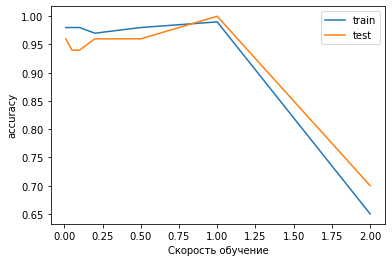

In [10]:
plt.plot(lr, acc_train, label='train')
plt.plot(lr, acc_test,  label='test')
plt.legend()
plt.xlabel('Скорость обучение')
plt.ylabel('accuracy')   
plt.show()

### Выводы:

- Увеличение скорости обучения позволяет быстрей достигать сходимости, но при этом большой шаг не позволяет нам с достаточной точностью определить минимум целевой функции. 
-  При малых значениях мы не успеваем достичь минимума, при больших недостаточно точно его определяем. Таким образом можно сказать, что у зависимости ошибки от скорости обучения должен иметься единственный максимум 

## Изменение результатов работы сети в завичсимости от числа итераций

In [11]:
inerations = [500, 5000, 10000, 15000, 20000, 25000, 30000]
acc_train = []
acc_test = []  
for iter_ in inerations:
    w = fit_neuro(X_train, y_train, neurons = 5, hidden_layers =1, inerations = iter_, lr = 0.01)  
    acc_train.append(accuracy(y_train, predict(w ,X_train)))
    acc_test.append(accuracy(y_test, predict(w ,X_test)))    

In [12]:
df = pd.DataFrame([acc_train, acc_test], columns=inerations)
result = pd.DataFrame(['train', 'test'], columns=['Кол-во итераций'])
result.join(df)

,Кол-во итераций,500,5000,10000,15000,20000,25000,30000
0,train,0.71,0.97,0.98,0.98,0.98,0.98,0.98
1,test,0.76,0.98,0.96,0.96,0.96,0.94,0.94


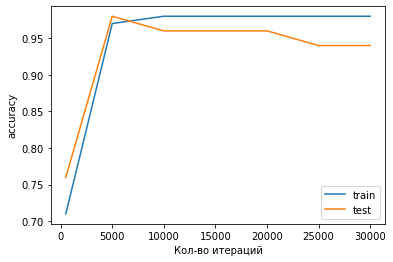

In [13]:
plt.plot(inerations, acc_train, label='train')
plt.plot(inerations, acc_test,  label='test')
plt.legend()
plt.xlabel('Кол-во итераций')
plt.ylabel('accuracy')   
plt.show()

### Выводы:

- Рассуждения аналогичны предыдущему пункту. Чем больше итераций, тем уверенней мы достигаем области минимума, но при этом возникает проблема переобучения, что можно заметить из результатов. 
- Зависимость также имеет один максимум

## Изменение результатов работы сети в завичсимости от количества нойронов в скрытом слое

In [14]:
neurons = [3,4,5,10,20,50]
acc_train = []
acc_test = []  
for neuro in neurons:
    w = fit_neuro(X_train, y_train, neurons = neuro, hidden_layers = 1, inerations = 10000, lr = 0.01)  
    acc_train.append(accuracy(y_train, predict(w ,X_train)))
    acc_test.append(accuracy(y_test, predict(w ,X_test)))    

In [15]:
df = pd.DataFrame([acc_train, acc_test], columns=neurons)
result = pd.DataFrame(['train', 'test'], columns=['кол-во нейронов'])
result.join(df)


,кол-во нейронов,3,4,5,10,20,50
0,train,0.98,0.98,0.98,0.98,0.98,0.98
1,test,0.96,0.96,0.96,0.96,0.96,0.96


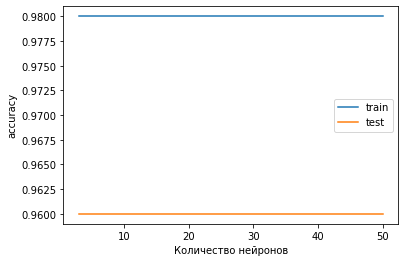

In [16]:
plt.plot(neurons, acc_train, label='train')
plt.plot(neurons, acc_test,  label='test')
plt.legend()
plt.xlabel('Количество нейронов')
plt.ylabel('accuracy')   
plt.show()

### Выводы:

- Как показал эксперимент явной зависимости ошибки от числа нейронов на данном датасете не наблюдается, это объясняется простотой самих данных. Можно предположить, что чем больше нейронов в сети тем больше "зависимостей" может выучить сеть, а это приведёт к переобучению. 


## Изменение результатов работы сети в завичсимости от количества скрытых слоев

In [17]:
hidden_layers = [1,2,3,4,5,6,7,8,9,10]
acc_train = []
acc_test = []  
for hidden in hidden_layers:
    w = fit_neuro(X_train, y_train, neurons = 5, hidden_layers =hidden, inerations = 10000, lr = 0.01)  
    acc_train.append(accuracy(y_train, predict(w ,X_train)))
    acc_test.append(accuracy(y_test, predict(w ,X_test)))    

In [18]:
df = pd.DataFrame([acc_train, acc_test], columns=hidden_layers)
result = pd.DataFrame(['train', 'test'], columns=['Кол-во скрытых слоёв'])
result.join(df)

,Кол-во скрытых слоёв,1,2,3,4,5,6,7,8,9,10
0,train,0.98,0.98,0.98,0.98,0.35,0.35,0.35,0.35,0.35,0.35
1,test,0.96,0.96,0.96,0.96,0.30,0.30,0.30,0.30,0.30,0.30


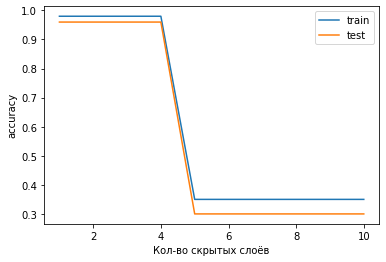

In [19]:
plt.plot(hidden_layers, acc_train, label='train')
plt.plot(hidden_layers, acc_test,  label='test')
plt.legend()
plt.xlabel('Кол-во скрытых слоёв')
plt.ylabel('accuracy')   
plt.show()

### Выводы:

- Большое число слоёв аналогично, как и большое количество нейронов может привести к переобучению. 
- Большое количество скрытых слоёв приводит к затуханию градиента. Мы можем наблюдать это на графике. 

## Итог:

In [20]:

w = fit_neuro(X_train, y_train, neurons = 5, hidden_layers =1, inerations = 10000, lr = 1)  
pred_train = predict(w ,X_train)
pred_test = predict(w ,X_test)
train = accuracy(y_train, pred_train)
test = accuracy(y_test, pred_test)
print(train, test)

0.99 1.0


In [21]:
print(classification_report(y_test.argmax(-1), pred_test.argmax(-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        15

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [22]:
print(multilabel_confusion_matrix(y_test.argmax(-1), pred_test.argmax(-1)))

[[[31  0]
  [ 0 19]]

 [[34  0]
  [ 0 16]]

 [[35  0]
  [ 0 15]]]


### Выводы по работе:

- Единица на тестовой выборке больше говорит скорее от простоте данных, чем о удачной конфигурации нейронной сети.
- С другой стороны, даже сеть собранная "на коленке" позволяет решать некоторые вопросы классификации с очень высокими показателями. 
- В работе не рассматривались разные функции активации, методы инициализации весов и стратегии оптимизации скорости обучения. На таком датасете увидеть плюсы и минусы практически очень сложно. 